# Neural Network for Regression

In [59]:
# pip install pandas tensorflow scikit-learn --user --upgrade

In [60]:
# pip install numpy==1.26.4 --user

In [61]:
# pip install matplotlib

In [62]:
# pip install scikeras

In [63]:
import os
import urllib
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Data

In [64]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"    



def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)  

    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)   


fetch_housing_data()


housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [65]:
train, test = train_test_split(housing, test_size=0.2, random_state=42)

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_id, test_id in split.split(housing, housing["income_cat"]):
    strat_train = housing.loc[train_id]
    strat_test = housing.loc[test_id]


housing = strat_train.drop("median_house_value", axis=1) 
housing_labels = strat_train["median_house_value"].copy()

sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY,2
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN,3
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN,3
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN,3
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN,5


In [66]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr.loc[sample_incomplete_rows.index.values]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,2.0
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,3.0
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,3.0
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,3.0
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,5.0


In [67]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,2.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,5.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,2.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,2.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,3.0


### Handling Text/Categorical Attributes

In [68]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


In [69]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

### One Hot Encoding

In [70]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [71]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [72]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

### Custom Transformers

In [73]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6     #columns

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [74]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [75]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [76]:
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names    

    def fit(self, X, y=None): 
        return self  
    
    def transform(self, X):
        return X[self.attribute_names].values
    


num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ]) 

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder()),
    ])

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])  


old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 214656 stored elements and shape (16512, 17)>

## Neural Network Model

In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(housing_prepared, housing_labels, test_size=0.2, random_state=42)

def build_model():
    model = keras.models.Sequential([
        keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    return model

model = build_model()
# model = KerasRegressor(model=build_model, epochs=20, batch_size=32, verbose=0)

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

predictions = model.predict(housing_prepared)

Epoch 1/100


C:\Users\annap\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 56308645888.0000 - mae: 207260.8750 - val_loss: 55491411968.0000 - val_mae: 205668.2656
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55368695808.0000 - mae: 205439.1250 - val_loss: 55452745728.0000 - val_mae: 205589.2812
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56862433280.0000 - mae: 207730.2188 - val_loss: 55390900224.0000 - val_mae: 205464.7812
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56427237376.0000 - mae: 207253.1094 - val_loss: 55305379840.0000 - val_mae: 205294.0000
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55446630400.0000 - mae: 205639.1719 - val_loss: 55200514048.0000 - val_mae: 205086.2656
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56753311744.0000 - mae: 208056.4844 - val_loss: 55078535168.0000 - val_mae: 204845.6562
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55867006976.0000 - mae: 206105.5625 - val_loss: 549395415

## Evaluate Performance

In [81]:
mae = mean_absolute_error(housing_labels, predictions)
print("MAE:", mae)

mse = mean_squared_error(housing_labels, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)


MAE: 94416.97807629673
MSE: 15542887817.576403
RMSE: 124671.1186184531


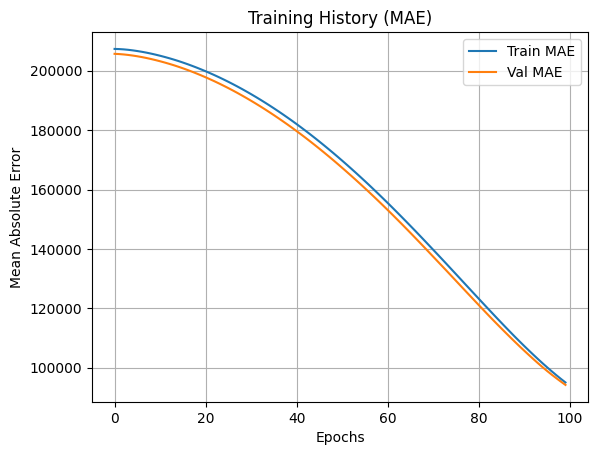

In [82]:
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE") 
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.title("Training History (MAE)")
plt.show()